# Energy (E) and Energy-Discrepancy (ED)

In [87]:
import torch

B, K, T = 50, 6, 0.5 # Batch size, Number of seen classes, Temperature
logits = torch.randn(B,K)

def e(logits):
    
    assert logits.dim()==2, "logits = [Batch size, Number of seen classes]"
    
    e = logits.div(T).exp().sum(1).log().mul(T).neg()

    return e

def ed(logits):
    
    assert logits.dim()==2, "logits = [Batch size, Number of seen classes]"
    
    ed = logits.div(T).exp().sum(1).log().mul(T) - (logits.div(T).exp().sum(1) - logits.div(T).exp().max(1)[0]).log().mul(T)

    return ed

# Seen and Unseen Class Idenfication - Unlabeled Data

### $D_{sc}=\{x_i^u|(ED(x_i^u)>\tau_1), i = 1,2,...,n \}$
### $D_{uc}=\{x_i^u|(ED(x_i^u)<\tau_2), i = 1,2,...,n \}$

In [88]:
TAU_ONE = .4 # Hyperparameter
TAU_TWO = max(TAU_ONE-0.1,0)

logits = torch.randn(B,K) # Logits of unlabeled samples

reliable_seen_class_logits = logits[ed(logits)>TAU_ONE] # D_sc
unseen_class_logits = logits[ed(logits)<TAU_TWO] # D_uc

# Loss functions
### Equation (1) = cross-entropy loss of $D_L$, where $D_L$ represents labeled data

In [89]:
import torch

logits_weak_augmented_labeled_data = torch.randn(B,K)
labels = torch.randint(low=0,high=K,size=(B,)).long()

eq_1 = torch.nn.functional.cross_entropy(logits_weak_augmented_labeled_data, labels)

### Equation (8) = confirmation bias elimination (CBE) loss of $D_{sc}$

In [90]:
logits_unlabeled_data = torch.randn(2*B,K)
# logits_unlabeled_data = model(torch.cat([weak_augmented_unlabeled_data, strong_augmented_unlabeled_data],axis=0))

logits_weak_augmented_unlabeled_data, logits_strong_augmented_unlabeled_data = logits_unlabeled_data.chunk(2)

ed_values = ed(logits_weak_augmented_unlabeled_data)
pseudo_label = logits_weak_augmented_unlabeled_data.argmax(1).detach()
weak_probs = logits_weak_augmented_unlabeled_data.softmax(1).detach()

eq_8_left = torch.nn.functional.cross_entropy(logits_strong_augmented_unlabeled_data[ed_values>TAU_ONE],pseudo_label[ed_values>TAU_ONE])
eq_8_right = torch.nn.functional.kl_div(input=logits_strong_augmented_unlabeled_data[ed_values>TAU_ONE].log_softmax(dim=1), target=weak_probs[ed_values>TAU_ONE], reduction='batchmean')

eq_8 = eq_8_left+eq_8_right

### Equation (9) = unseen-class label distribution (UCD) loss of $D_{uc}$

In [91]:
uniform = torch.ones_like(weak_probs[ed_values<TAU_TWO]) / K
eq_9_losses = torch.nn.functional.kl_div(input=logits_strong_augmented_unlabeled_data[ed_values<TAU_TWO].log_softmax(dim=1), target=uniform, reduction='none').sum(1)

weight = ((ed_values[ed_values<TAU_TWO].max()-ed_values[ed_values<TAU_TWO]) / ed_values[ed_values<TAU_TWO].max()).exp()
eq_9 = (weight*eq_9_losses).mean()

# Algorithm

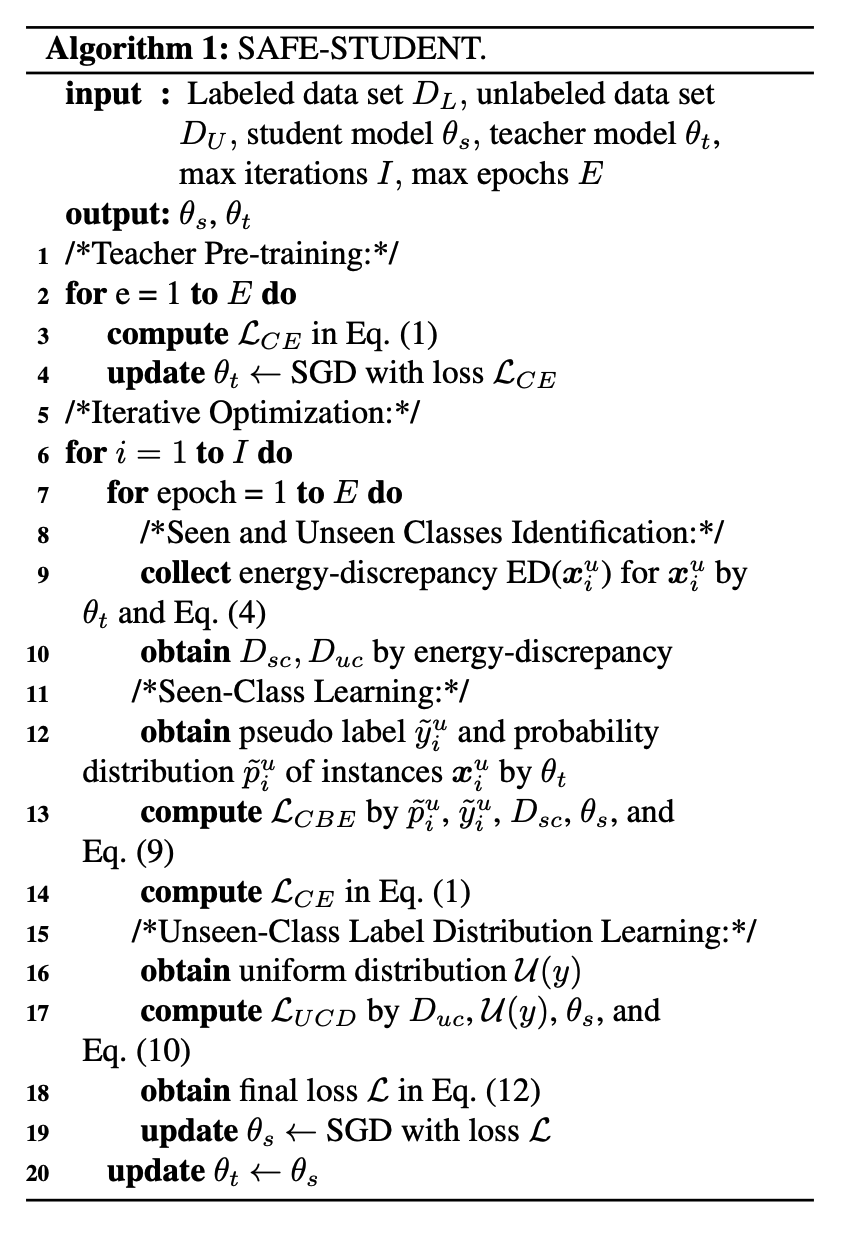